In [81]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [82]:
import numpy as np
import pandas as pd
import datetime as dt
from sqlalchemy import inspect

# Reflect Tables into SQLAlchemy ORM

In [83]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [84]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [85]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [86]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [87]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [88]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Inspect Database (Tables)

In [89]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [90]:
columns = inspector.get_columns('measurement')
for column in columns:
    primarykeystr = ""
    if column['primary_key'] == 1:
        primarykeystr = "Primary Key"
    print(column["name"],column["type"],primarykeystr)

id INTEGER Primary Key
station TEXT 
date TEXT 
prcp FLOAT 
tobs FLOAT 


In [91]:
columns = inspector.get_columns('station')
for column in columns:
    primarykeystr = ""
    if column['primary_key'] == 1:
        primarykeystr = "Primary Key"
    print(column["name"], column["type"], primarykeystr)

id INTEGER Primary Key
station TEXT 
name TEXT 
latitude FLOAT 
longitude FLOAT 
elevation FLOAT 


# Exploratory Precipitation Analysis

In [92]:
# Find the most recent date in the data set. Note date = text (string)
session.query(func.count(Measurement.date)).all()

recent_dt_str = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
earliest_dt_str = session.query(Measurement.date).order_by(Measurement.date).first()

print(f"Earliest: {earliest_dt_str[0]} , Latest: {recent_dt_str[0]}")



Earliest: 2010-01-01 , Latest: 2017-08-23


In [93]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
recent_date = dt.datetime.strptime(recent_dt_str[0], '%Y-%m-%d')

# Calculate the date one year from the last date in data set.
recent_date_one_year = dt.date(recent_date.year -1, recent_date.month, recent_date.day)
recent_date_one_year

# Perform a query to retrieve the data and precipitation scores
sel = [Measurement.date,Measurement.prcp]
mea_query_result = session.query(*sel).filter(Measurement.date>= recent_date_one_year).all()
mea_query_result

# Save the query results as a Pandas DataFrame
prcp_df = pd.DataFrame(mea_query_result, columns=['Date','Precipitation'])

# Clean up non value entries
prcp_df = prcp_df.dropna(how='any') 

# Sort the dataframe by date
prcp_df = prcp_df.sort_values(["Date"], ascending=True)

# Set the index ro rhe date column
prcp_df = prcp_df.set_index("Date")
prcp_df

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.70
2016-08-23,0.15
...,...
2017-08-22,0.50
2017-08-23,0.00
2017-08-23,0.08


<Figure size 864x720 with 0 Axes>

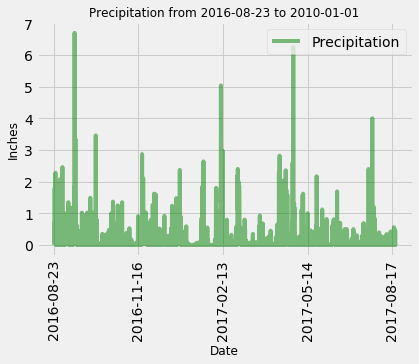

In [94]:
# Use Pandas Plotting with Matplotlib to plot the data
x = prcp_df.index.tolist()
y = prcp_df["Precipitation"].tolist()
#x
#y

plt.figure(figsize=(12,10))
prcp_df.plot(color= "green", alpha=0.5, rot=90)
plt.title(f"Precipitation from {recent_date_one_year} to {earliest_dt_str[0]}", fontsize=12)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Inches", fontsize=12)
plt.grid(which="major", axis="both", linestyle="-")
plt.legend(loc ='upper right')


plt.savefig("/Users/tanishacooper/code/sqlalchemy-challenge/Images/precipitation.png")
plt.show()

In [95]:
# Use Pandas to calcualte the summary statistics for the precipitation data
round_prcp_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [97]:
# Design a query to calculate the total number stations in the dataset
session.query(Station.id).count()

9

In [99]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station,func.count(Measurement.station)).group_by(Measurement.station)\
.order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [103]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_num = 'USC00519281'
temp = session.query(func.min(Measurement.tobs),
             func.max(Measurement.tobs),
             func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station_num).all()
print(f"The lowest, highest, and average temperature recorded for {most_active_station_num} were {temp}.")

The lowest, highest, and average temperature recorded for USC00519281 were [(54.0, 85.0, 71.66378066378067)].


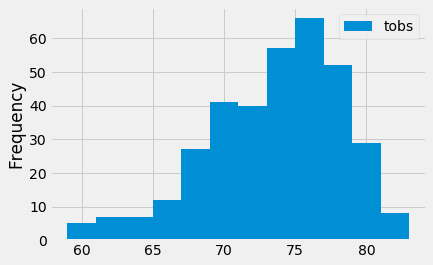

In [115]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_most_active_temp_obser = active_stations[0][0]

one_year_temp_obs = session.query(Measurement.date, Measurement.tobs).\
                                filter(Measurement.date >= "2016-08-24").\
                                filter(Measurement.date <= "2017-08-23").\
                                filter(Measurement.station == station_most_active_temp_obser).all()

one_year_temp_obs_df = pd.DataFrame(one_year_temp_obs)
one_year_temp_obs_df

one_year_temp_obs_df.plot.hist(bins=12)

plt.savefig("/Users/tanishacooper/code/sqlalchemy-challenge/Images/station_temp_frequency_histogram.png")
plt.show()

# Close session

In [116]:
# Close Session
session.close()